In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fonctions d’activation
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def sigmoid(x):
    """
    Sigmoid activation: 1 / (1 + exp(-x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    # Clip x to avoid overflow in exp(-x) for large negative x
    # and underflow for large positive x leading to 1/(1+0) = 1
    clipped_x = np.clip(x, -500, 500)
    result = 1 / (1 + np.exp(-clipped_x))
    # Add small epsilon to prevent exact 0 or 1 for log loss calculation later
    epsilon = 1e-15
    result = np.clip(result, epsilon, 1 - epsilon)
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    """
    Derivative of sigmoid: sigmoid(x) * (1 - sigmoid(x))
    """
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    s = sigmoid(x)
    result = s * (1 - s)
    assert np.all((result >= 0) & (result <= 0.25 + 1e-9)), "Sigmoid derivative must be in [0, 0.25]"
    # Added small tolerance for floating point inaccuracies
    return result


In [ ]:
# Classe NeuralNetwork
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, reg_lambda=0.01, optimizer='sgd', beta1=0.9 ,beta2=0.99 ,epsilon=1e-9):

        """
        Initialize the neural network with given layer sizes, learning rate, and L2 regularization strength.
        layer_sizes: List of integers [input_size, hidden1_size, ..., output_size]
        learning_rate: Step size for gradient descent
        reg_lambda: L2 regularization parameter (lambda)
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert isinstance(reg_lambda, (int, float)) and reg_lambda >= 0, "Regularization lambda must be non-negative"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda # Regularization parameter
        self.optimizer = optimizer
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.weights = []
        self.biases = []
        self.activations = [] # To store A^[l] during forward pass
        self.z_values = []    # To store Z^[l] during forward pass
        self.d_weights = []   # To store dW^[l] during backward pass
        self.d_biases = []    # To store db^[l] during backward pass

        # Initialisation des poids et biais
        np.random.seed(42) # for reproducibility
        for i in range(len(layer_sizes) - 1):
            # Using He initialization for ReLU layers, Xavier/Glorot for sigmoid (output)
            # Or simply scaled random initialization as hinted by seed setting
            # Let's use Xavier/Glorot initialization which works reasonably well for both
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            # w = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1]))
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]) # He init
            # w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01 # Simple small random values
            b = np.zeros((1, layer_sizes[i+1])) # Initialize biases to zero

            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape. Expected {(layer_sizes[i], layer_sizes[i+1])}, got {w.shape}"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape. Expected {(1, layer_sizes[i+1])}, got {b.shape}"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward propagation: Z^[l] = A^[l-1] W^[l] + b^[l], A^[l] = g(Z^[l])
        Stores intermediate Z and A values in self.z_values and self.activations.
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X] # A^[0] is the input X
        self.z_values = []
        A = X

        # Hidden layers (using ReLU)
        for i in range(len(self.weights) - 1):
            W = self.weights[i]
            b = self.biases[i]
            Z = A @ W + b
            assert Z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{i+1} has incorrect shape. Expected {(X.shape[0], self.layer_sizes[i+1])}, got {Z.shape}"
            self.z_values.append(Z)
            A = relu(Z)
            assert A.shape == (X.shape[0], self.layer_sizes[i+1]), f"A^{i+1} has incorrect shape. Expected {(X.shape[0], self.layer_sizes[i+1])}, got {A.shape}"
            self.activations.append(A)

        # Output layer (using Sigmoid)
        W_out = self.weights[-1]
        b_out = self.biases[-1]
        Z_out = A @ W_out + b_out
        assert Z_out.shape == (X.shape[0], self.layer_sizes[-1]), f"Output Z has incorrect shape. Expected {(X.shape[0], self.layer_sizes[-1])}, got {Z_out.shape}"
        self.z_values.append(Z_out)
        output = sigmoid(Z_out)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), f"Output A has incorrect shape. Expected {(X.shape[0], self.layer_sizes[-1])}, got {output.shape}"
        self.activations.append(output)

        return self.activations[-1] # Return final activation A^[L]

    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy: J = -1/m * sum(y * log(y_pred) + (1-y) * log(1-y_pred))
        Includes L2 Regularization term: J_reg = J + (lambda / 2m) * sum(||W^[l]||^2_F)
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, f"y_true ({y_true.shape}) and y_pred ({y_pred.shape}) must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"

        m = y_true.shape[0]
        # Add epsilon to prevent log(0)
        epsilon = 1e-15
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

        # Binary Cross-Entropy Loss
        cost = - (1/m) * np.sum(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))

        # L2 Regularization Term
        l2_cost = 0
        if self.reg_lambda > 0:
            for W in self.weights:
                l2_cost += np.sum(np.square(W))
            l2_cost = (self.reg_lambda / (2 * m)) * l2_cost

        total_loss = cost + l2_cost
        total_loss = np.squeeze(total_loss) # Ensure loss is scalar

        assert not np.isnan(total_loss), "Loss computation resulted in NaN"
        assert not np.isinf(total_loss), "Loss computation resulted in Inf"
        return total_loss

    def compute_accuracy(self, y_true, y_pred_prob):
        """
        Compute accuracy: proportion of correct predictions.
        Predictions are made by thresholding probabilities at 0.5.
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred_prob, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred_prob.shape, f"y_true ({y_true.shape}) and y_pred_prob ({y_pred_prob.shape}) must have the same shape"

        y_pred_labels = (y_pred_prob >= 0.5).astype(int)
        accuracy = np.mean(y_pred_labels == y_true)

        assert 0 <= accuracy <= 1, f"Accuracy ({accuracy}) must be between 0 and 1"
        return accuracy

    def backward(self, X, y):
        """
        Backpropagation: compute dW^[l], db^[l] for each layer.
        Uses stored values from the forward pass (self.activations, self.z_values).
        Includes L2 regularization gradient term.
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.activations[-1]
        assert y.shape == outputs.shape, f"y ({y.shape}) and outputs ({outputs.shape}) must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        # Output layer (L)
        # dZ^[L] = A^[L] - y (for sigmoid and binary cross-entropy)
        dZ = outputs - y
        assert dZ.shape == outputs.shape, f"dZ for output layer has incorrect shape. Expected {outputs.shape}, got {dZ.shape}"

        A_prev = self.activations[-2]
        W_curr = self.weights[-1]
        # dW^[L] = (1/m) * A^[L-1].T @ dZ^[L] + (lambda/m) * W^[L]
        self.d_weights[-1] = (A_prev.T @ dZ) / m + (self.reg_lambda / m) * W_curr
        # db^[L] = (1/m) * sum(dZ^[L], axis=0)
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        assert self.d_weights[-1].shape == W_curr.shape
        assert self.d_biases[-1].shape == self.biases[-1].shape

        # Hidden layers (l = L-1 down to 1)
        dA_prev = dZ # Initialize dA for the last hidden layer

        for i in range(len(self.weights) - 2, -1, -1):
            # dA^[l] = dZ^[l+1] @ W^[l+1].T
            W_next = self.weights[i+1]
            dA = dA_prev @ W_next.T

            # dZ^[l] = dA^[l] * g'(Z^[l]) where g is ReLU
            Z = self.z_values[i]
            dZ = dA * relu_derivative(Z)
            assert dZ.shape == Z.shape, f"dZ^{i+1} has incorrect shape. Expected {Z.shape}, got {dZ.shape}"

            A_prev = self.activations[i] # A^[l-1]
            W_curr = self.weights[i]
            # dW^[l] = (1/m) * A^[l-1].T @ dZ^[l] + (lambda/m) * W^[l]
            self.d_weights[i] = (A_prev.T @ dZ) / m + (self.reg_lambda / m) * W_curr
            # db^[l] = (1/m) * sum(dZ^[l], axis=0)
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

            assert self.d_weights[i].shape == W_curr.shape
            assert self.d_biases[i].shape == self.biases[i].shape

            dA_prev = dZ # Pass dA gradient backward for next iteration

    def update_parameters(self):
        """
        Update weights and biases using the selected optimizer (SGD or Adam).
        For SGD:
            W = W - learning_rate * dW
            b = b - learning_rate * db
        For Adam:
            Uses moving averages of gradients and squared gradients for adaptive updates.
        """
        if not hasattr(self, 'optimizer'):
            raise ValueError("Optimizer type must be specified ('sgd' or 'adam')")

        if self.optimizer.lower() == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.d_weights[i]
                self.biases[i] -= self.learning_rate * self.d_biases[i]

        elif self.optimizer.lower() == 'adam':
            beta1 = self.beta1
            beta2 = self.beta2
            epsilon = self.epsilon

            # Initialize moment vectors if not present
            if not hasattr(self, 'm_weights'):
                self.m_weights = [np.zeros_like(w) for w in self.weights]
                self.v_weights = [np.zeros_like(w) for w in self.weights]
                self.m_biases = [np.zeros_like(b) for b in self.biases]
                self.v_biases = [np.zeros_like(b) for b in self.biases]
                self.t = 0

            self.t += 1
            for i in range(len(self.weights)):
                # Update biased first moment estimate
                self.m_weights[i] = beta1 * self.m_weights[i] + (1 - beta1) * self.d_weights[i]
                self.m_biases[i] = beta1 * self.m_biases[i] + (1 - beta1) * self.d_biases[i]

                # Update biased second raw moment estimate
                self.v_weights[i] = beta2 * self.v_weights[i] + (1 - beta2) * (self.d_weights[i] ** 2)
                self.v_biases[i] = beta2 * self.v_biases[i] + (1 - beta2) * (self.d_biases[i] ** 2)

                # Compute bias-corrected first moment estimate
                m_hat_w = self.m_weights[i] / (1 - beta1 ** self.t)
                m_hat_b = self.m_biases[i] / (1 - beta1 ** self.t)

                # Compute bias-corrected second raw moment estimate
                v_hat_w = self.v_weights[i] / (1 - beta2 ** self.t)
                v_hat_b = self.v_biases[i] / (1 - beta2 ** self.t)

                # Update parameters
                self.weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + epsilon)
                self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        else:
            raise ValueError("Unsupported optimizer. Use 'sgd' or 'adam'.")


    def train(self, X, y, X_val, y_val, epochs, batch_size ):
        """
        Train the neural network using mini-batch SGD, with validation.
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        m = X.shape[0]
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        print(f"Starting training for {epochs} epochs with batch size {batch_size}...")

        for epoch in range(epochs):
            # Shuffle training data
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]

            epoch_train_loss = 0
            num_batches = 0

            for i in range(0, m, batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i : i + batch_size]
                y_batch = y_shuffled[i : i + batch_size]

                # Forward pass
                outputs = self.forward(X_batch)
                # Compute loss for the batch (used for monitoring, not gradient calculation)
                batch_loss = self.compute_loss(y_batch, outputs)
                epoch_train_loss += batch_loss
                num_batches += 1

                # Backward pass
                self.backward(X_batch, y_batch)

                # Update parameters
                self.update_parameters()

            # Calculate average loss and accuracy for the epoch on training set
            avg_epoch_train_loss = epoch_train_loss / num_batches
            train_pred = self.forward(X) # Predict on full training set
            train_accuracy = self.compute_accuracy(y, train_pred)
            # Recompute train loss on the full set for consistency with validation loss
            train_loss_full = self.compute_loss(y, train_pred)

            # Calculate loss and accuracy on validation set
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss_full)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_full:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        print("Training finished.")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels (0 or 1) by running forward propagation
        and thresholding the output probability at 0.5.
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        # Perform forward pass to get probabilities
        probabilities = self.forward(X)
        # Convert probabilities to binary predictions
        predictions = (probabilities >= 0.5).astype(int)

        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), f"Predictions have incorrect shape. Expected {(X.shape[0], self.layer_sizes[-1])}, got {predictions.shape}"
        return predictions


In [ ]:
# Charger et préparer les données
print("Loading and preparing data...")
try:
    data = pd.read_csv('diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found. Please make sure the file is in the same directory.")
    exit()

Loading and preparing data...


In [ ]:
# Replace zeros with NaN, then impute with median
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, np.nan)
    median_val = data[col].median()
    data[col] = data[col].fillna(median_val)
    print(f"Imputed 0s in '{col}' with median: {median_val:.2f}")

Imputed 0s in 'Glucose' with median: 117.00
Imputed 0s in 'BloodPressure' with median: 72.00
Imputed 0s in 'SkinThickness' with median: 29.00
Imputed 0s in 'Insulin' with median: 125.00
Imputed 0s in 'BMI' with median: 32.30


In [ ]:
# Separate features (X) and target (y)
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1) # Reshape y to be a column vector (m, 1)

assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, f"Expected 8 features in input data, found {X.shape[1]}"
assert y.shape[1] == 1, f"Expected y to have 1 column, found {y.shape[1]}"

In [ ]:
# Diviser les données en entraînement, validation et test (60% train, 20% val, 20% test)
print("Splitting data into train, validation, and test sets...")
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42) # 0.25 * 0.8 = 0.2

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Splitting data into train, validation, and test sets...
Train set: 460 samples
Validation set: 154 samples
Test set: 154 samples


In [ ]:
# Standardisation: X = (X - mu) / sigma (Fit on training data only!)
print("Standardizing data...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Use mean/std from training set
X_test = scaler.transform(X_test) # Use mean/std from training set
print("Data standardization complete.")

Standardizing data...
Data standardization complete.


In [ ]:
input_size = X_train.shape[1]
output_size = 1
# Configuration from PDF: 2 hidden layers (16 and 8 neurons)
layer_sizes = [input_size, 16, 8, output_size]
learning_rate = 0.5
epochs = 200
batch_size = 128
reg_lambda = 0.5 # Added L2 regularization strength

In [ ]:
# Créer et entraîner le modèle
print("Creating and training the SGD model...")
nn_sgd = NeuralNetwork(layer_sizes, learning_rate=learning_rate, reg_lambda=reg_lambda, optimizer='sgd')
train_losses, val_losses, train_accuracies, val_accuracies = nn_sgd.train(
    X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size
)

Creating and training the SGD model...
Starting training for 200 epochs with batch size 128...
Epoch 10/200, Train Loss: 0.4681, Val Loss: 0.5116, Train Acc: 0.7870, Val Acc: 0.7662
Epoch 20/200, Train Loss: 0.4426, Val Loss: 0.4998, Train Acc: 0.8217, Val Acc: 0.7662
Epoch 30/200, Train Loss: 0.4188, Val Loss: 0.4849, Train Acc: 0.8174, Val Acc: 0.7727
Epoch 40/200, Train Loss: 0.4095, Val Loss: 0.4823, Train Acc: 0.8217, Val Acc: 0.7792
Epoch 50/200, Train Loss: 0.4020, Val Loss: 0.4789, Train Acc: 0.8326, Val Acc: 0.7662
Epoch 60/200, Train Loss: 0.3929, Val Loss: 0.4836, Train Acc: 0.8326, Val Acc: 0.7857
Epoch 70/200, Train Loss: 0.3885, Val Loss: 0.4723, Train Acc: 0.8348, Val Acc: 0.7662
Epoch 80/200, Train Loss: 0.3948, Val Loss: 0.4923, Train Acc: 0.8413, Val Acc: 0.7792
Epoch 90/200, Train Loss: 0.4027, Val Loss: 0.5043, Train Acc: 0.8196, Val Acc: 0.7338
Epoch 100/200, Train Loss: 0.3779, Val Loss: 0.4851, Train Acc: 0.8435, Val Acc: 0.7922
Epoch 110/200, Train Loss: 0.3824,

In [ ]:
# Prédictions et évaluation sur l'ensemble de test
print("Evaluating model on the test set...")
y_pred_test_sgd = nn_sgd.predict(X_test)

print("\nClassification Report (Test set):")
# Use scikit-learn's classification_report
print(classification_report(y_test, y_pred_test_sgd, target_names=['Non-Diabetic (0)', 'Diabetic (1)']))


Evaluating model on the test set...

Classification Report (Test set):
                  precision    recall  f1-score   support

Non-Diabetic (0)       0.81      0.75      0.78       100
    Diabetic (1)       0.59      0.67      0.63        54

        accuracy                           0.72       154
       macro avg       0.70      0.71      0.70       154
    weighted avg       0.73      0.72      0.72       154



In [ ]:
# Calculate individual metrics for clarity
test_accuracy = accuracy_score(y_test, y_pred_test_sgd)
test_precision = precision_score(y_test, y_pred_test_sgd)
test_recall = recall_score(y_test, y_pred_test_sgd)
test_f1 = f1_score(y_test, y_pred_test_sgd)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.7208
Test Precision: 0.5902
Test Recall: 0.6667
Test F1-Score: 0.6261


Generating Confusion Matrix...


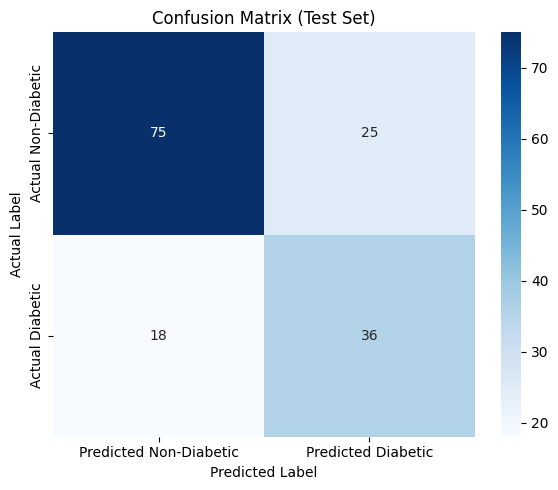

In [ ]:
# Matrice de confusion
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_test_sgd)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Diabetic', 'Predicted Diabetic'],
            yticklabels=['Actual Non-Diabetic', 'Actual Diabetic'])
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()


# plt.show() # Avoid showing plot directly in non-interactive environment


Generating Loss and Accuracy Curves...


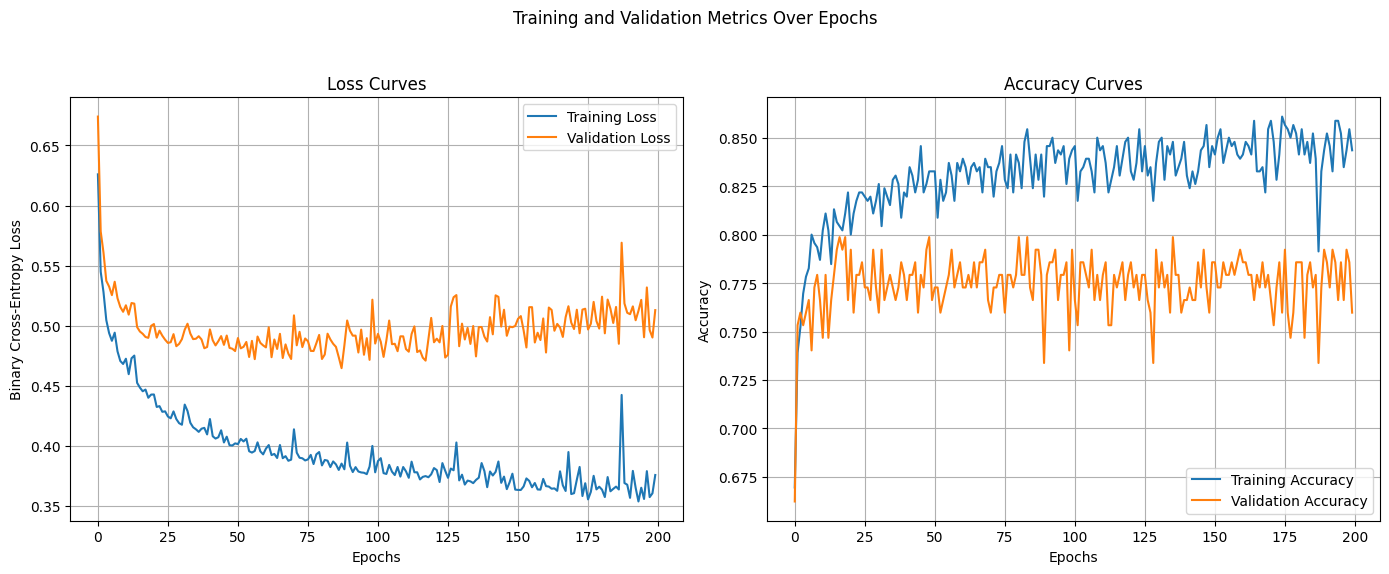

In [ ]:

# Courbes de perte et d’accuracy
print("Generating Loss and Accuracy Curves...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Courbe de perte
ax1.plot(range(epochs), train_losses, label='Training Loss')
ax1.plot(range(epochs), val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Binary Cross-Entropy Loss')
ax1.legend()
ax1.grid(True)

# Courbe d'accuracy
ax2.plot(range(epochs), train_accuracies, label='Training Accuracy')
ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.suptitle('Training and Validation Metrics Over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap


In [ ]:
# Créer et entraîner le modèle
print("Creating and training the ADAM model...")
nn_adam = NeuralNetwork(layer_sizes, learning_rate=learning_rate, reg_lambda=reg_lambda, optimizer='adam', beta1=0.9, beta2=0.999, epsilon=1e-8)
train_losses, val_losses, train_accuracies, val_accuracies = nn_adam.train(
    X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size
)

Creating and training the ADAM model...
Starting training for 200 epochs with batch size 128...
Epoch 10/200, Train Loss: 0.6253, Val Loss: 0.6995, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 20/200, Train Loss: 0.5537, Val Loss: 0.5451, Train Acc: 0.6348, Val Acc: 0.6623
Epoch 30/200, Train Loss: 0.5024, Val Loss: 0.5146, Train Acc: 0.7891, Val Acc: 0.7597
Epoch 40/200, Train Loss: 0.5313, Val Loss: 0.5194, Train Acc: 0.7457, Val Acc: 0.7727
Epoch 50/200, Train Loss: 0.5412, Val Loss: 0.5524, Train Acc: 0.7174, Val Acc: 0.7338
Epoch 60/200, Train Loss: 0.4747, Val Loss: 0.4842, Train Acc: 0.7935, Val Acc: 0.7922
Epoch 70/200, Train Loss: 0.4599, Val Loss: 0.4487, Train Acc: 0.7870, Val Acc: 0.7597
Epoch 80/200, Train Loss: 0.4792, Val Loss: 0.4858, Train Acc: 0.7804, Val Acc: 0.7792
Epoch 90/200, Train Loss: 0.4600, Val Loss: 0.4710, Train Acc: 0.8022, Val Acc: 0.7727
Epoch 100/200, Train Loss: 0.4770, Val Loss: 0.5081, Train Acc: 0.7870, Val Acc: 0.7857
Epoch 110/200, Train Loss: 0.4688

In [ ]:
# Prédictions et évaluation sur l'ensemble de test
print("Evaluating model on the test set...")
y_pred_test_adam = nn_adam.predict(X_test)

print("\nClassification Report (Test set):")
# Use scikit-learn's classification_report
print(classification_report(y_test, y_pred_test_adam, target_names=['Non-Diabetic (0)', 'Diabetic (1)']))


Evaluating model on the test set...

Classification Report (Test set):
                  precision    recall  f1-score   support

Non-Diabetic (0)       0.82      0.75      0.78       100
    Diabetic (1)       0.60      0.69      0.64        54

        accuracy                           0.73       154
       macro avg       0.71      0.72      0.71       154
    weighted avg       0.74      0.73      0.73       154



In [ ]:
# Calculate individual metrics for clarity
test_accuracy = accuracy_score(y_test, y_pred_test_adam)
test_precision = precision_score(y_test, y_pred_test_adam)
test_recall = recall_score(y_test, y_pred_test_adam)
test_f1 = f1_score(y_test, y_pred_test_adam)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.7273
Test Precision: 0.5968
Test Recall: 0.6852
Test F1-Score: 0.6379


Generating Confusion Matrix...


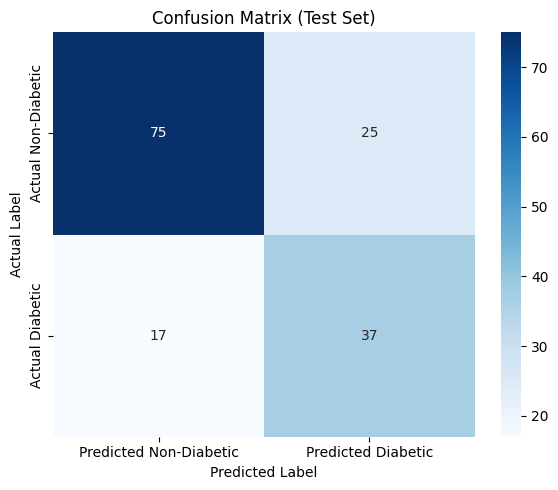

In [ ]:
# Matrice de confusion
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_test_adam)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Diabetic', 'Predicted Diabetic'],
            yticklabels=['Actual Non-Diabetic', 'Actual Diabetic'])
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()


# plt.show() # Avoid showing plot directly in non-interactive environment


Generating Loss and Accuracy Curves...


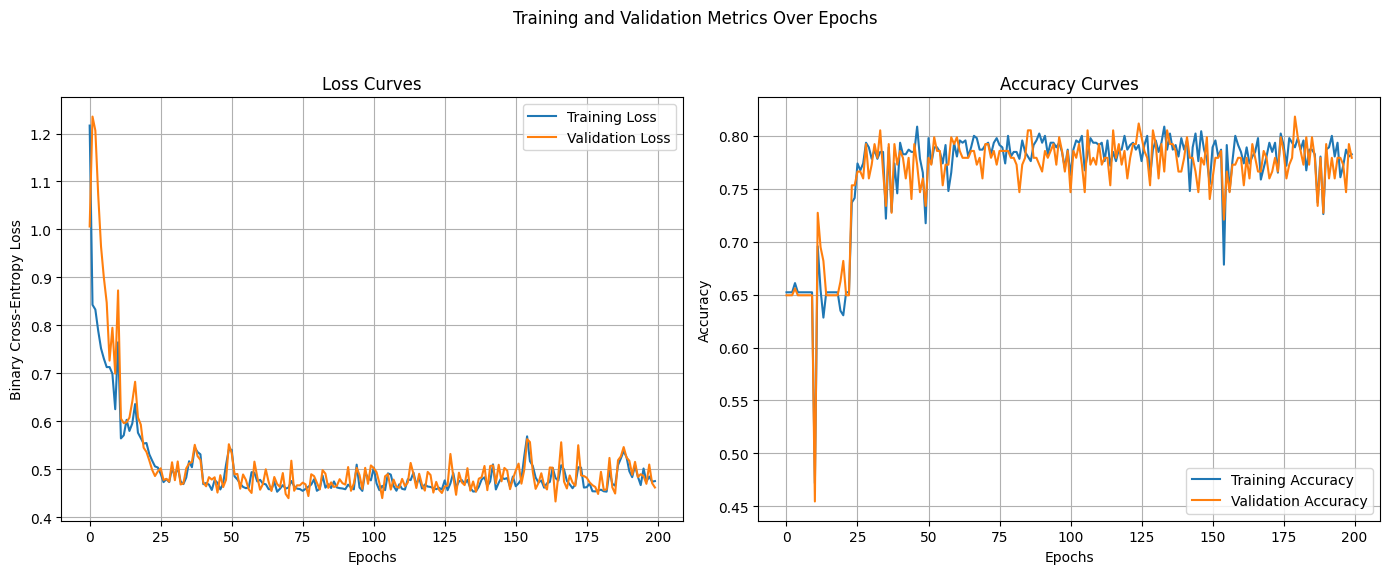

In [ ]:

# Courbes de perte et d’accuracy
print("Generating Loss and Accuracy Curves...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Courbe de perte
ax1.plot(range(epochs), train_losses, label='Training Loss')
ax1.plot(range(epochs), val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Binary Cross-Entropy Loss')
ax1.legend()
ax1.grid(True)

# Courbe d'accuracy
ax2.plot(range(epochs), train_accuracies, label='Training Accuracy')
ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.suptitle('Training and Validation Metrics Over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
